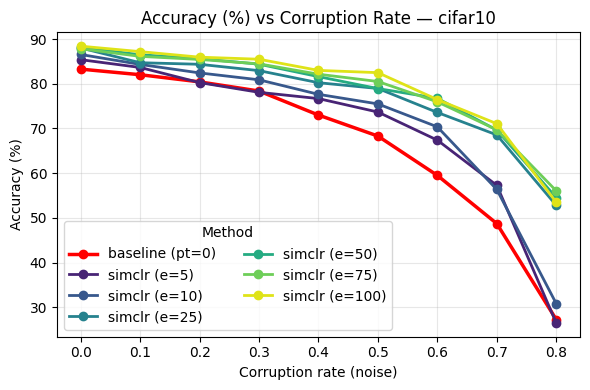

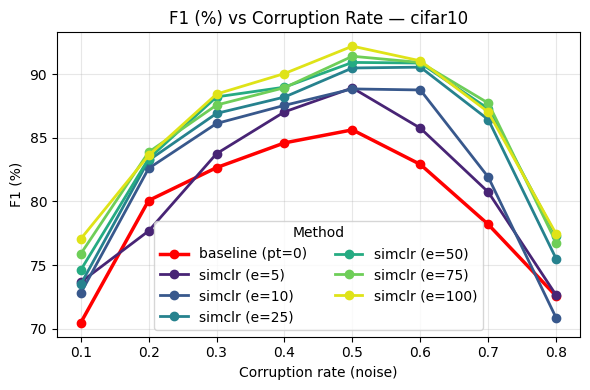

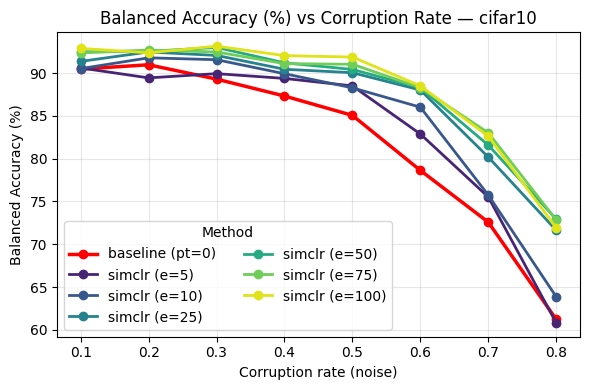

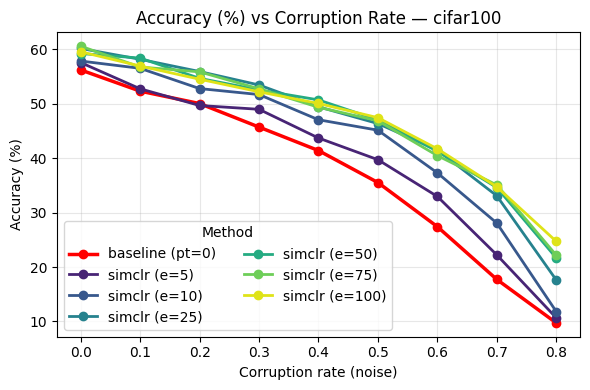

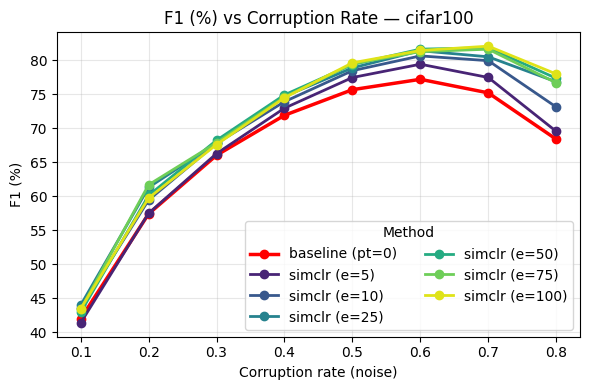

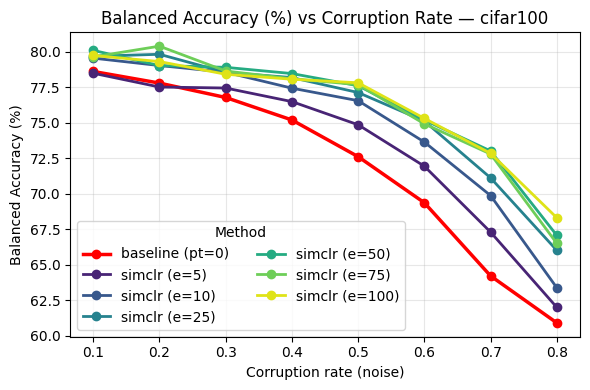

In [21]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ---------- helpers ----------
def get_dataset(name: str):
    n = name.lower()
    if "cifar100" in n: return "cifar100"
    if "cifar10"  in n: return "cifar10"
    m = re.search(r"_c(\d+)", name, re.I)
    return f"c{m.group(1)}" if m else "unknown"

def get_pt_epochs(name: str, pretrain_field: int):
    m = re.search(r"_e(\d+)", name)
    return int(m.group(1)) if m else int(pretrain_field or 0)

def is_baseline(name: str):
    return name.lower().startswith("baseline")

def is_pretrained(name: str):
    n = name.lower()
    # extend as you add methods
    return n.startswith(("simclr","byol","simsiam","barlow"))
    
def get_pt_epochs(name: str, pretrain_field=None):
    n = name.lower()
    # explicit "preE-<k>" takes priority: simclr_cifar10_preE-5_supE-10...
    m = re.search(r"pre[e-]?[-_]?(\d+)", n)        # matches preE-5, pre-5, pree5
    if m: return int(m.group(1))
    # special-case pure SSL dirs like: simclr_cifar10_e100_s1
    if is_pretrained(n):
        m2 = re.search(r"(?:^|[_-])e(\d+)(?:$|[_-])", n)
        if m2: return int(m2.group(1))
    # fallback (rare): use provided field if any
    return int(pretrain_field or 0)

def strip_seed(name: str):
    """Remove seed pattern like '_s-1' or 's1' from experiment name."""
    return re.sub(r"[_-]s[-_]?\d+$", "", name)

def ci_get(df, names):
    if df is None or df.empty: return None
    if isinstance(names, str): names = [names]
    low = {c.lower(): c for c in df.columns}
    for n in names:
        if n in df.columns: return df[n]
        if n.lower() in low: return df[low[n.lower()]]
    return None

def get_ssl_method(name: str):
    n = str(name).lower()
    for m in ("simclr", "byol", "simsiam", "barlow"):
        if n.startswith(m):
            return m
    if n.startswith("baseline"):
        return "baseline"
    return "unknown"

def extract_metrics_from_csv(csv_path: Path):
    if not csv_path.exists():
        return (None, None, None)
    try:
        df = pd.read_csv(csv_path)
    except Exception:
        return (None, None, None)
    acc_ser = ci_get(df, ["test_acc","val_acc","accuracy","acc","top1"])
    acc_val = None
    if acc_ser is not None:
        acc_val = pd.to_numeric(acc_ser, errors="coerce").dropna()
        if len(acc_val):
            acc_val = float(acc_val.iloc[-1])
            if acc_val <= 1.5:
                acc_val *= 100.0
    f1_ser = ci_get(df, ["cl_f1","f1","F1"])
    f1_val = None
    if f1_ser is not None:
        f1_vals = pd.to_numeric(f1_ser, errors="coerce").dropna()
        if len(f1_vals):
            f1_val = float(f1_vals.iloc[-1]) * (100.0 if f1_vals.iloc[-1] <= 1.5 else 1.0)
    ba_ser = ci_get(df, ["cl_bal_acc","balanced_accuracy","bal_acc","BA"])
    ba_val = None
    if ba_ser is not None:
        ba_vals = pd.to_numeric(ba_ser, errors="coerce").dropna()
        if len(ba_vals):
            ba_val = float(ba_vals.iloc[-1]) * (100.0 if ba_vals.iloc[-1] <= 1.5 else 1.0)
    return (acc_val, f1_val, ba_val)

def aggregate_metric(df_in, metric):
    df = df_in.dropna(subset=[metric]).copy()

    # Ensure SSL_method exists (some callers may pass a filtered df without it)
    if "SSL_method" not in df.columns:
        def _infer_ssl(name: str):
            n = str(name).lower()
            for m in ("simclr", "byol", "simsiam", "barlow"):
                if n.startswith(m):
                    return m
            if n.startswith("baseline"):
                return "baseline"
            return "unknown"
        src = "exp" if "exp" in df.columns else ("exp_base" if "exp_base" in df.columns else None)
        df["SSL_method"] = df[src].map(_infer_ssl) if src else "unknown"

    g = (df.groupby(["dataset", "SSL_method", "noise", "pt_epochs"], as_index=False)[metric]
            .mean(numeric_only=True)
            .sort_values(["dataset", "SSL_method", "pt_epochs", "noise"]))
    return g



def _plot_metric(agg_df, metric_name: str, ylabel: str):
    for ds, g in agg_df.groupby("dataset"):
        plt.figure(figsize=(6, 4))

        # --- Baseline (always red) ---
        base = g[(g["pt_epochs"] == 0) | (g["SSL_method"].str.lower() == "baseline")]
        if not base.empty:
            for method, gb in base.groupby("SSL_method"):
                gb = gb.sort_values("noise")
                plt.plot(
                    gb["noise"],
                    gb[metric_name],
                    marker="o",
                    linewidth=2.5,
                    color="red",
                    label=f"{method} (pt=0)"
                )

        # --- SSL lines ---
        nonbase = g[(g["pt_epochs"] > 0) & (g["SSL_method"].str.lower() != "baseline")]
        if not nonbase.empty:
            groups = sorted(
                nonbase.groupby(["SSL_method", "pt_epochs"]),
                key=lambda t: (t[0][0], t[0][1])
            )
            cmap = plt.cm.viridis
            colors = cmap(np.linspace(0.1, 0.95, len(groups)))

            for color, ((method, pe), sub) in zip(colors, groups):
                sub = sub.sort_values("noise")
                plt.plot(
                    sub["noise"],
                    sub[metric_name],
                    marker="o",
                    linewidth=2.0,
                    color=color,
                    label=f"{method} (e={pe})"
                )

        # --- Final plot styling ---
        plt.title(f"{ylabel} vs Corruption Rate — {ds}")
        plt.xlabel("Corruption rate (noise)")
        plt.ylabel(ylabel)
        plt.grid(True, alpha=0.3)
        plt.legend(title="Method", ncol=2)
        plt.tight_layout()
        plt.show()





# ---------- main function ----------
def plot_corruption_curves_for_dataset(dataset: str,
                                       ssl_method: str,
                                       base_dir: Path = Path.cwd(),
                                       results_dir_prefix: str = "results_"):
    """
    Scan results_{dataset} for experiment folders, parse/aggregate metrics, and plot curves.
    Returns (agg_acc, agg_f1, agg_ba) as DataFrames.
    """
    ds_key = dataset.lower()
    root = base_dir / f"{results_dir_prefix}{ds_key}"

    # Build results table from folders
    rows = []
    if root.exists():
        for d in sorted(root.glob("*")):
            if not d.is_dir():
                continue
            csv, log = d/"metrics.csv", d/"logs.txt"
    
            acc, f1, bal_acc = extract_metrics_from_csv(csv)
            if acc is None and log.exists():
                try:
                    txt = log.read_text(errors="ignore")
                    m = re.search(r"Final.*Acc.*?([0-9]+(?:\.[0-9]+)?)\s*%", txt, re.I)
                    if m: acc = float(m.group(1))
                except:
                    pass
            if acc is None and f1 is None and bal_acc is None:
                continue
    
            m_noise = re.search(r"noise[-_= ]?(\d*\.?\d+)", d.name, re.I)
            noise = float(m_noise.group(1)) if m_noise else np.nan
            if noise > 1: noise /= 100.0  # accept 50 -> 0.5
    
            rows.append({
                "exp": d.name,
                "noise": noise,
                "acc": acc,
                "f1": f1,
                "bal_acc": bal_acc
            })
    results = pd.DataFrame(rows)
    if results.empty:
        print(f"No results to plot for dataset '{dataset}'. Looked in: {root}")
        return (pd.DataFrame(), pd.DataFrame(), pd.DataFrame())

    # Clean/derive fields
    df = results.copy()
    for col in ["noise","acc","f1","bal_acc"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    
    df["dataset"] = df["exp"].astype(str).map(get_dataset)
    df["pt_epochs"] = [get_pt_epochs(n, None) for n in df["exp"].astype(str)]
    df["is_baseline"] = df["exp"].str.lower().str.startswith("baseline")
    df.loc[df["is_baseline"], "pt_epochs"] = 0
    df["is_pretrained"] = df["exp"].astype(str).map(is_pretrained)
    df["SSL_method"] = df["exp"].astype(str).map(get_ssl_method)

    df.loc[df["is_baseline"], "pt_epochs"] = 0
    df["dataset"] = df["dataset"].fillna("unknown")

    #df_temp = df[df["noise"].isin([0.9])]
    #print(df_temp)

    # --- Group by experiment type (average over seeds) ---
    df["exp_base"] = df["exp"].map(strip_seed)
    
    group_cols = ["exp_base", "dataset", "noise", "pt_epochs"]
    metric_cols = ["acc", "f1", "bal_acc"]
    
    g = df.groupby(group_cols, as_index=False)

    # means over seeds
    df_means  = g[metric_cols].mean(numeric_only=True)
    
    # number of seeds aggregated per group
    df_counts = g.size().rename(columns={"size": "n_seeds"})
    
    # combine
    df_grouped = df_means.merge(df_counts, on=group_cols, how="left")
    
    # Replace exp with the seedless version for plotting
    df = df_grouped.rename(columns={"exp_base": "exp"})
    
    #print(df)
    
    # Metric-specific filtering of pretrain epochs (optional)
    df_acc = df.copy()
    df_f1  = df.copy()
    df_ba  = df.copy()

    # Metric-specific filtering of pretrain epochs
    df_acc = df[~df["pt_epochs"].isin([1])]
    df_acc = df_acc[~df_acc["noise"].isin([0.9])]
    df_f1 = df[~df["pt_epochs"].isin([1, 2])]
    df_f1 = df_f1[~df_f1["noise"].isin([0.0, 0.9])]
    df_ba = df[~df["pt_epochs"].isin([1, 2])]
    df_ba = df_ba[~df_ba["noise"].isin([0.0, 0.9])]


    #df_acc = df.copy()
    #df_f1  = df.copy()
    #df_ba  = df.copy()
    
    # Aggregate
    agg_acc = aggregate_metric(df_acc, "acc")
    agg_f1  = aggregate_metric(df_f1,  "f1")
    agg_ba  = aggregate_metric(df_ba,  "bal_acc")
    

    
    agg_acc = agg_acc[agg_acc["SSL_method"].isin(['baseline', ssl_method])]
    agg_f1  = agg_f1[agg_f1["SSL_method"].isin(['baseline', ssl_method])]
    agg_ba  = agg_ba[agg_ba["SSL_method"].isin(['baseline', ssl_method])]
    


    # Plot
    if not agg_acc.empty: _plot_metric(agg_acc, "acc", "Accuracy (%)")
    if not agg_f1.empty:  _plot_metric(agg_f1,  "f1",  "F1" + (" (%)" if agg_f1["f1"].max() and agg_f1["f1"].max()>1.5 else ""))
    if not agg_ba.empty:  _plot_metric(agg_ba,  "bal_acc", "Balanced Accuracy" + (" (%)" if agg_ba["bal_acc"].max() and agg_ba["bal_acc"].max()>1.5 else ""))

    return agg_acc, agg_f1, agg_ba



agg10_acc, agg10_f1, agg10_ba = plot_corruption_curves_for_dataset("cifar10", "simclr")
agg100_acc, agg100_f1, agg100_ba = plot_corruption_curves_for_dataset("cifar100", "simclr")

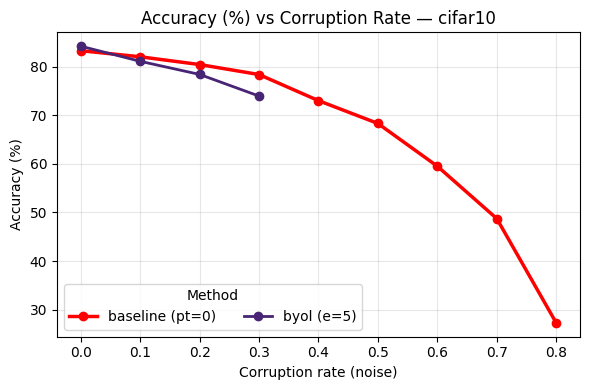

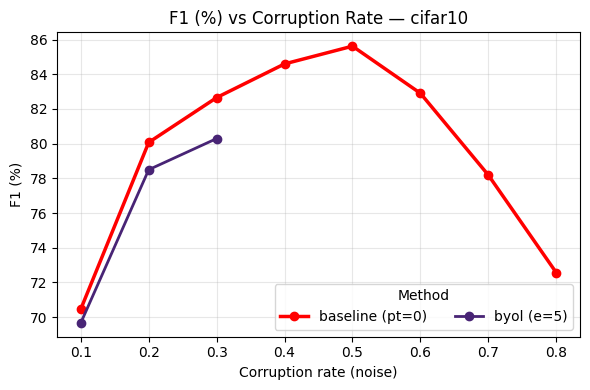

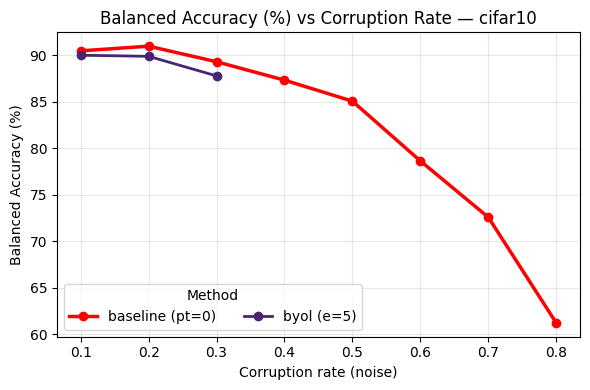

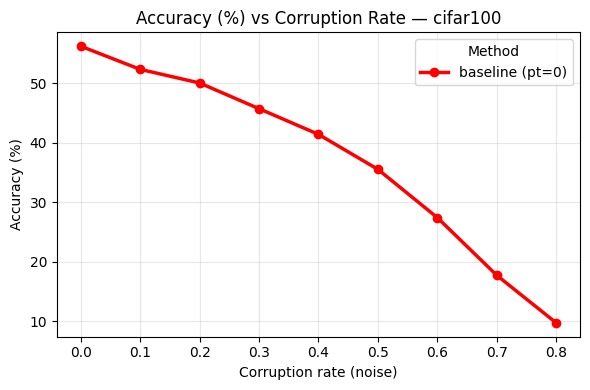

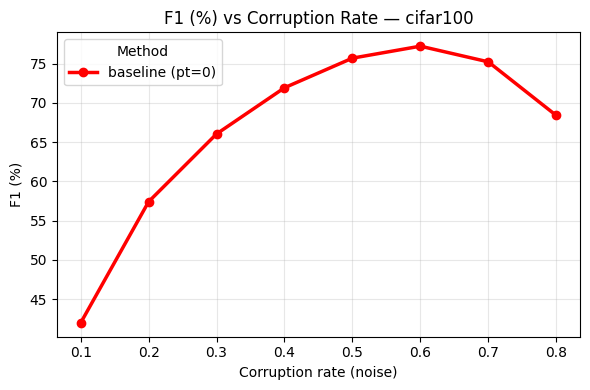

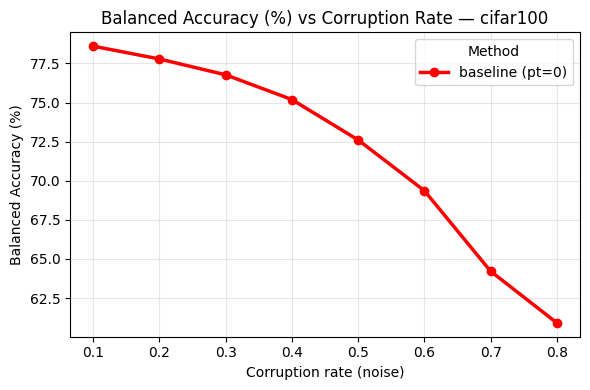

In [17]:
agg10_acc, agg10_f1, agg10_ba = plot_corruption_curves_for_dataset("cifar10", "byol")
agg100_acc, agg100_f1, agg100_ba = plot_corruption_curves_for_dataset("cifar100", "byol")

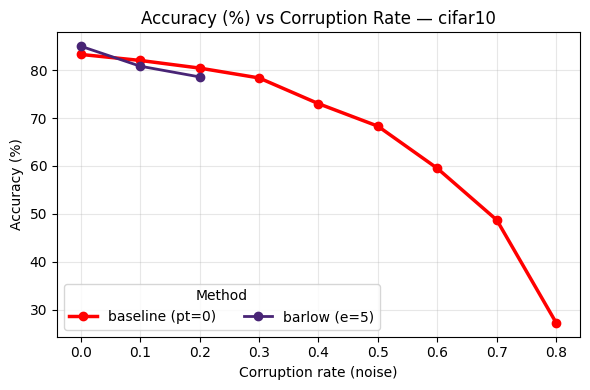

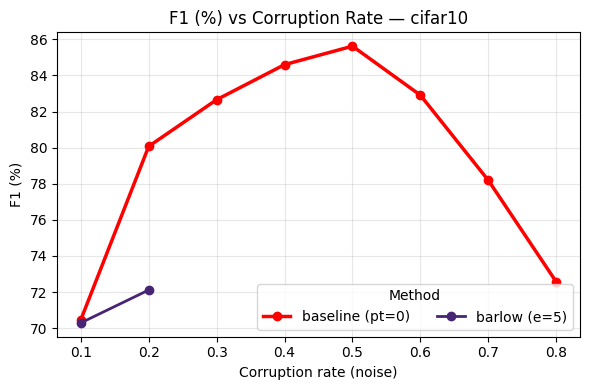

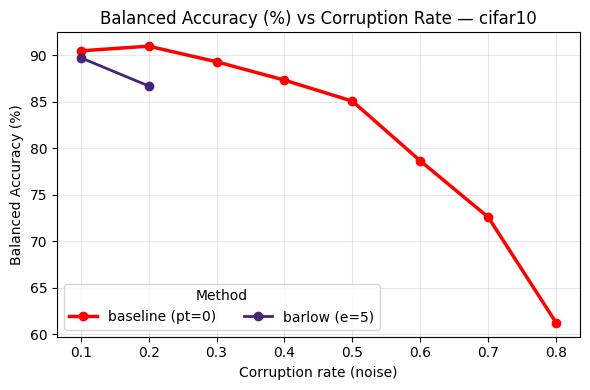

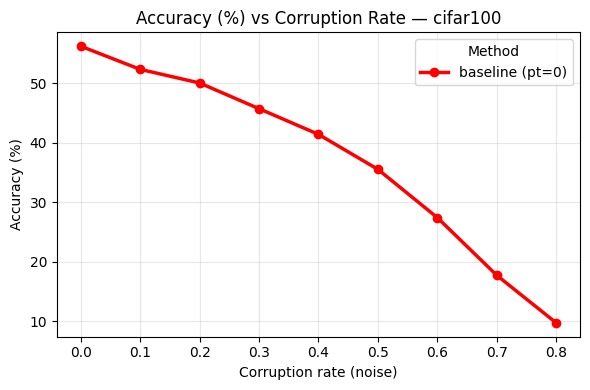

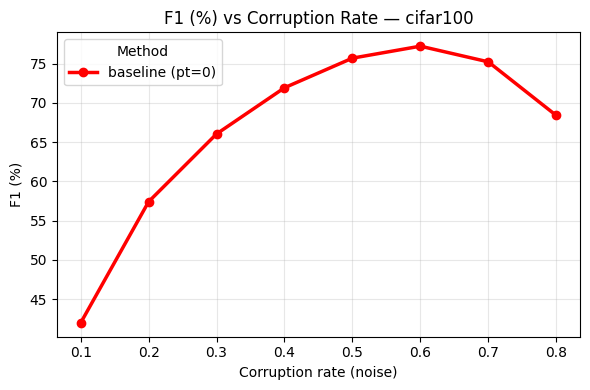

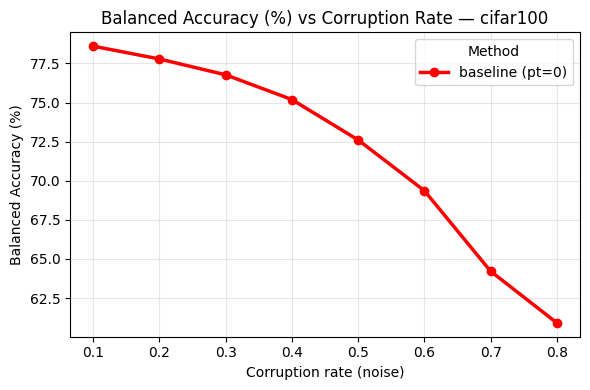

In [18]:
agg10_acc, agg10_f1, agg10_ba = plot_corruption_curves_for_dataset("cifar10", "barlow")
agg100_acc, agg100_f1, agg100_ba = plot_corruption_curves_for_dataset("cifar100", "barlow")

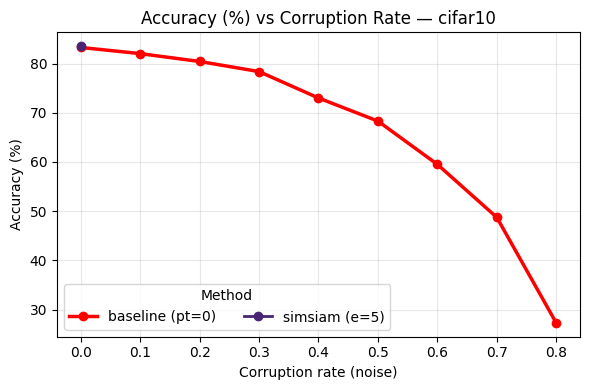

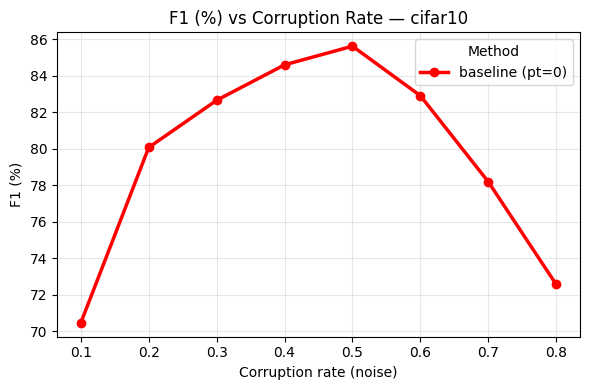

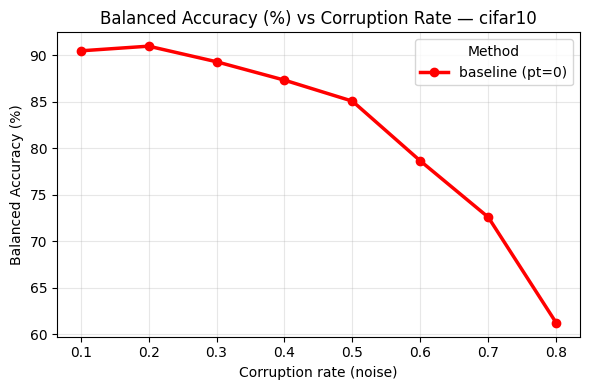

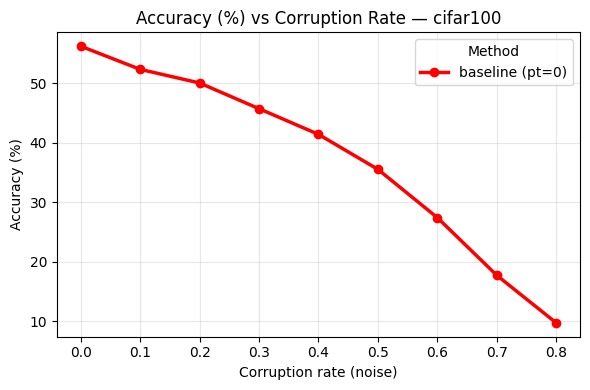

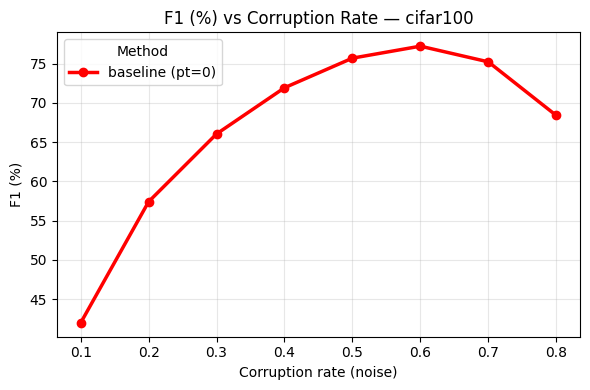

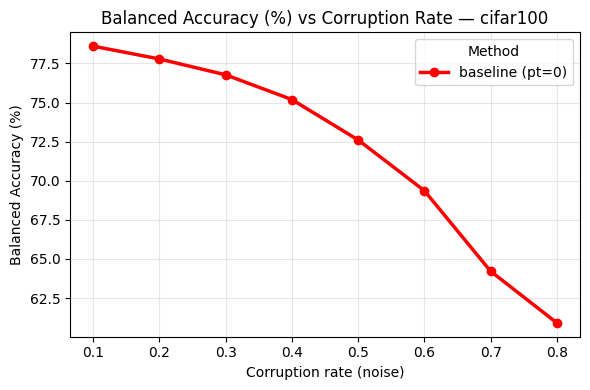

In [19]:
agg10_acc, agg10_f1, agg10_ba = plot_corruption_curves_for_dataset("cifar10", "simsiam")
agg100_acc, agg100_f1, agg100_ba = plot_corruption_curves_for_dataset("cifar100", "simsiam")

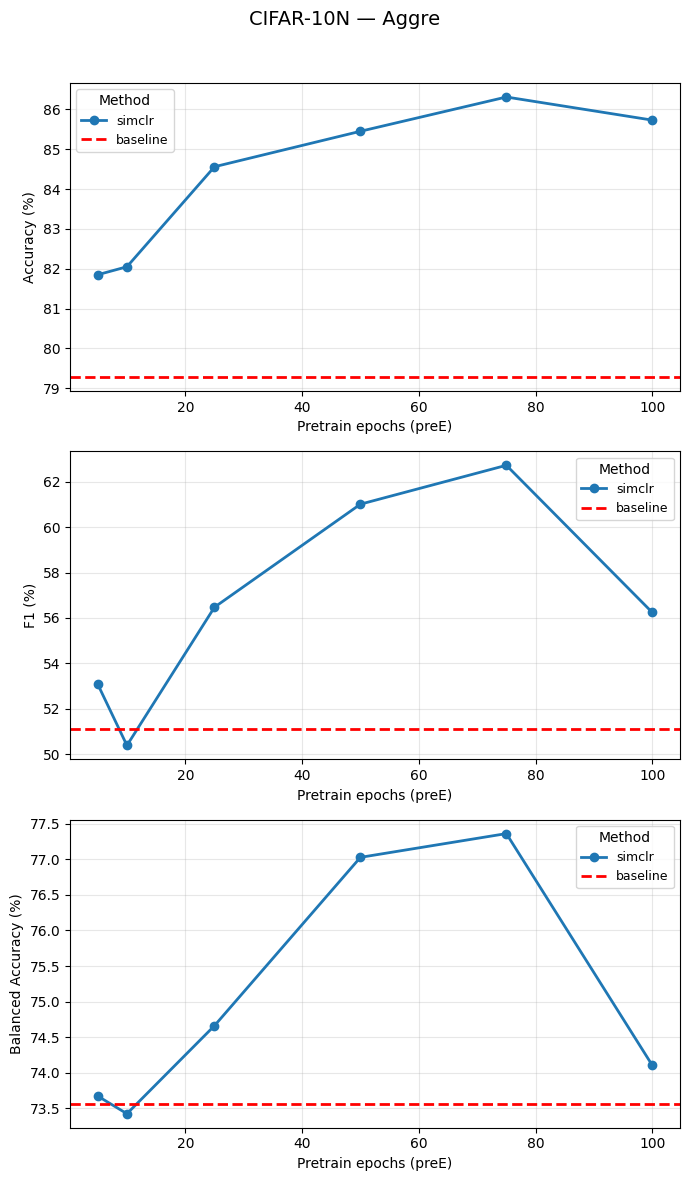

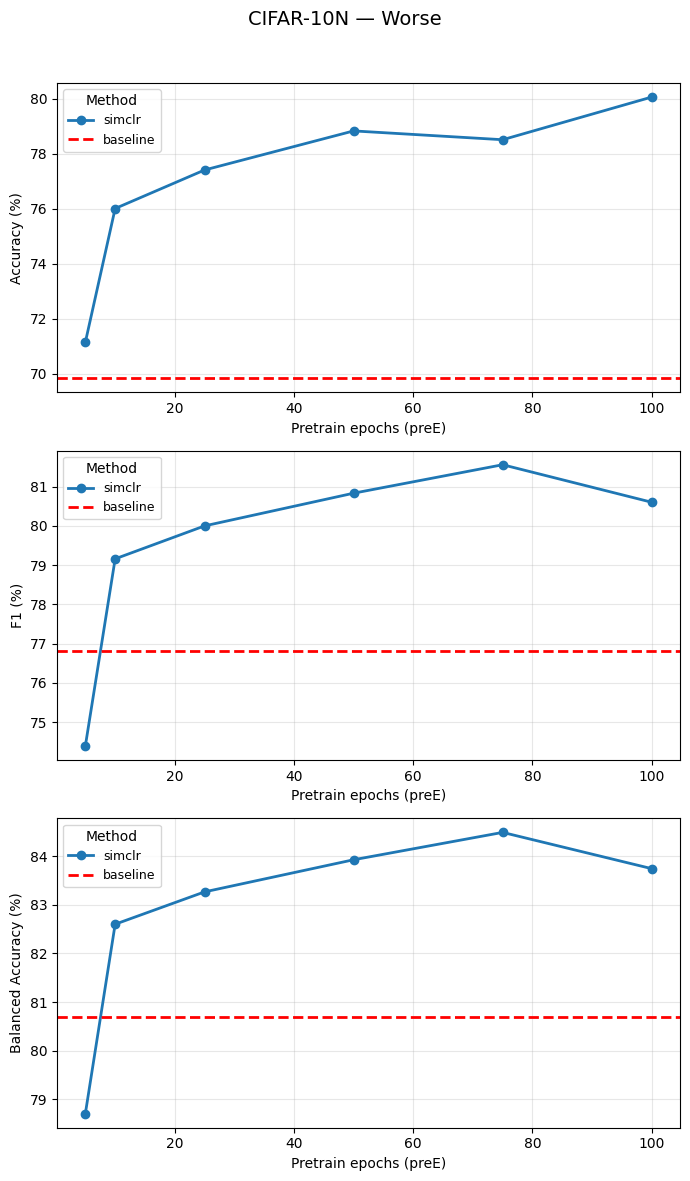

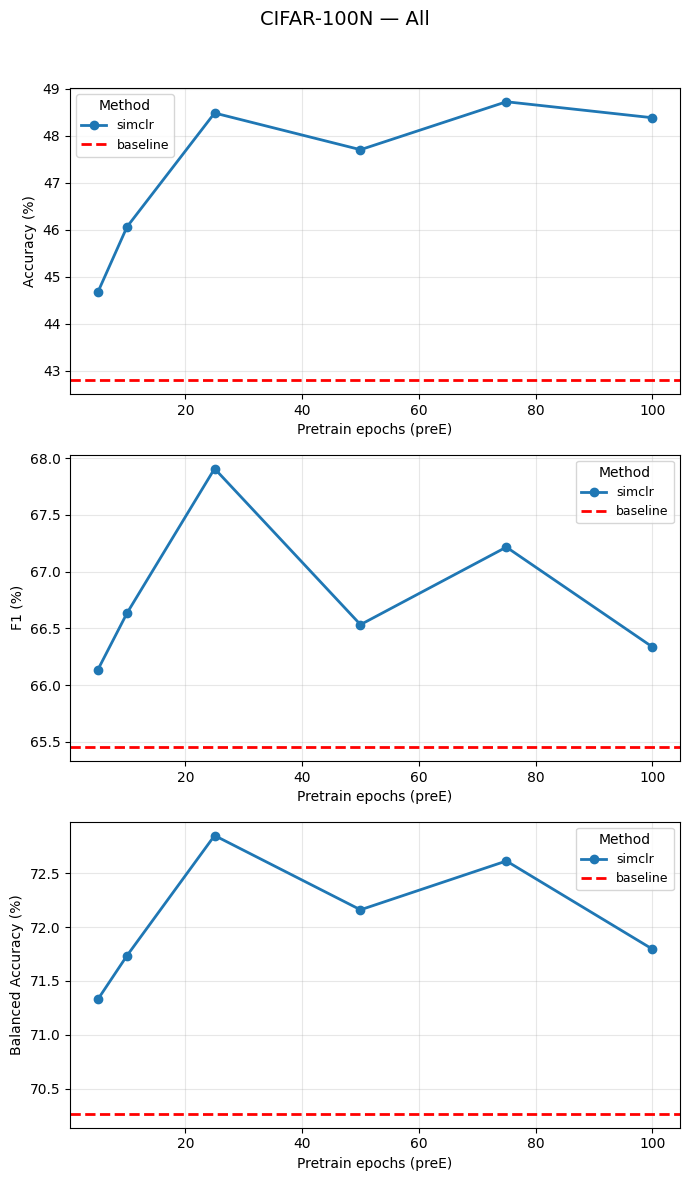

In [29]:
# --- imports ---
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# =========================
# Helpers for parsing names
# =========================
def get_dataset(name: str):
    n = name.lower()
    if "cifar-10n" in n or "cifar10n" in n:
        return "cifar-10n"
    if "cifar-100n" in n or "cifar100n" in n:
        return "cifar-100n"
    return "unknown"

def get_variant(name: str):
    """
    For CIFAR-10N return 'Aggre' or 'Worse'. For CIFAR-100N return 'all'.
    """
    n = name.lower()
    if "cifar-10n" in n or "cifar10n" in n:
        m = re.search(r"cifar[-_]?10n[-_](aggre|worse)", n, re.I)
        return (m.group(1).capitalize() if m else "Unknown")
    if "cifar-100n" in n or "cifar100n" in n:
        return "All"  # no sub-variants for 100N
    return "Unknown"

def get_ssl_method(name: str):
    n = str(name).lower()
    for m in ("simclr", "byol", "simsiam", "barlow"):
        if n.startswith(m):
            return m
    if n.startswith("baseline"):
        return "baseline"
    return "unknown"

def get_pt_epochs(name: str, pretrain_field=None):
    """
    Extract pretraining epochs. Matches preE-<k>, preE_<k>, pre-<k>, pree<k>.
    Baseline -> 0.
    """
    n = name.lower()
    m = re.search(r"pre[e-]?[-_]?(\d+)", n)
    if m:
        return int(m.group(1))
    if get_ssl_method(n) == "baseline":
        return 0
    return int(pretrain_field or 0)

def strip_seed(name: str):
    """Remove trailing seed token like '_s-1' or '-s1'."""
    return re.sub(r"[_-]s[-_]?\d+$", "", name)

# =========================
# CSV metric extraction
# =========================
def _ci_get(df, names):
    if df is None or df.empty: return None
    if isinstance(names, str): names = [names]
    low = {c.lower(): c for c in df.columns}
    for n in names:
        if n in df.columns: return df[n]
        if n.lower() in low: return df[low[n.lower()]]
    return None

def extract_metrics_from_csv(csv_path: Path):
    """
    Returns (acc, f1, bal_acc) as floats (percent if needed).
    Grabs the final non-NaN value from common column name variants.
    """
    if not csv_path.exists():
        return (None, None, None)
    try:
        df = pd.read_csv(csv_path)
    except Exception:
        return (None, None, None)

    # accuracy
    acc_ser = _ci_get(df, ["test_acc","val_acc","accuracy","acc","top1"])
    acc_val = None
    if acc_ser is not None:
        acc_vals = pd.to_numeric(acc_ser, errors="coerce").dropna()
        if len(acc_vals):
            acc_val = float(acc_vals.iloc[-1])
            if acc_val <= 1.5:
                acc_val *= 100.0

    # f1
    f1_ser = _ci_get(df, ["cl_f1","f1","F1"])
    f1_val = None
    if f1_ser is not None:
        f1_vals = pd.to_numeric(f1_ser, errors="coerce").dropna()
        if len(f1_vals):
            f1_val = float(f1_vals.iloc[-1])
            if f1_val <= 1.5:
                f1_val *= 100.0

    # balanced accuracy
    ba_ser = _ci_get(df, ["cl_bal_acc","balanced_accuracy","bal_acc","BA"])
    ba_val = None
    if ba_ser is not None:
        ba_vals = pd.to_numeric(ba_ser, errors="coerce").dropna()
        if len(ba_vals):
            ba_val = float(ba_vals.iloc[-1])
            if ba_val <= 1.5:
                ba_val *= 100.0

    return (acc_val, f1_val, ba_val)

# =========================
# Scanning + aggregation
# =========================
def scan_results(base_dir: Path):
    """
    Walk immediate subfolders of base_dir, read metrics.csv, and build a tidy DataFrame.
    Expected folder layout:
      base_dir/
        baseline_cifar-10n-Aggre_supE-10_s-1/
          metrics.csv
        simclr_cifar-10n-Worse_preE-50_supE-10_s-1/
          metrics.csv
        simclr_cifar-100n_preE-100_supE-10_s-1/
          metrics.csv
        ...
    """
    rows = []
    for d in sorted(base_dir.glob("*")):
        if not d.is_dir():
            continue
        csv = d / "metrics.csv"
        acc, f1, ba = extract_metrics_from_csv(csv)
        if acc is None and f1 is None and ba is None:
            continue

        rows.append({
            "exp": d.name,
            "exp_base": strip_seed(d.name),
            "dataset": get_dataset(d.name),            # 'cifar-10n' / 'cifar-100n' / unknown
            "variant": get_variant(d.name),            # Aggre/Worse for 10N; All for 100N
            "ssl": get_ssl_method(d.name),             # baseline / simclr / ...
            "pt_epochs": get_pt_epochs(d.name, None),  # preE
            "acc": acc,
            "f1": f1,
            "bal_acc": ba,
        })

    df = pd.DataFrame(rows)
    if df.empty:
        print(f"No metrics found under: {base_dir}")
        return df

    # numeric + clean
    for c in ["pt_epochs","acc","f1","bal_acc"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # normalize baseline epochs
    df.loc[df["ssl"].str.lower()=="baseline", "pt_epochs"] = 0

    # aggregate across seeds (same exp_base)
    gcols = ["exp_base","dataset","variant","ssl","pt_epochs"]
    metrics = ["acc","f1","bal_acc"]
    g = df.groupby(gcols, as_index=False)
    df_mean = g[metrics].mean(numeric_only=True)
    df_cnt  = g.size().rename(columns={"size":"n_seeds"})
    out = df_mean.merge(df_cnt, on=gcols, how="left")
    return out

# =========================
# Plotting
# =========================
def _add_baseline_hline(ax, df_variant, metric_col, label="baseline"):
    base = df_variant[df_variant["ssl"].str.lower()=="baseline"][metric_col].dropna()
    if not base.empty:
        y = base.mean()
        ax.axhline(y, color="red", linestyle="--", linewidth=2, label=label)

def _plot_variant(df_variant: pd.DataFrame, dataset_label: str, variant_label: str):
    """
    For a (dataset, variant) slice, plot:
      - Accuracy (%) vs pretrain epochs (lines per SSL method)
      - F1 (%) vs pretrain epochs
      - Balanced Acc (%) vs pretrain epochs
    Baseline is a red dashed horizontal line.
    """
    if df_variant.empty:
        print(f"[{dataset_label} — {variant_label}] No data to plot.")
        return

    # methods excluding baseline for lines
    methods = [m for m in sorted(df_variant["ssl"].unique()) if m.lower() != "baseline"]

    # make a 3x1 stack
    fig, axes = plt.subplots(3, 1, figsize=(7, 12))
    fig.suptitle(f"{dataset_label} — {variant_label}", fontsize=14)

    def _plot(ax, metric_col, ylabel):
        # lines: one per SSL method (excluding baseline)
        for method in methods:
            gm = df_variant[df_variant["ssl"]==method].sort_values("pt_epochs")
            if gm.empty or gm[metric_col].isna().all():
                continue
            ax.plot(gm["pt_epochs"], gm[metric_col], marker="o", linewidth=2, label=method)

        # baseline: dashed red horizontal line
        _add_baseline_hline(ax, df_variant, metric_col, label="baseline")

        ax.set_xlabel("Pretrain epochs (preE)")
        ax.set_ylabel(ylabel)
        ax.grid(True, alpha=0.3)
        ax.legend(title="Method", fontsize=9)

    # Accuracy
    if df_variant["acc"].notna().any():
        _plot(axes[0], "acc", "Accuracy (%)")
    else:
        axes[0].set_visible(False)

    # F1
    if df_variant["f1"].notna().any():
        # label with (%) if values look like percents
        ylab = "F1 (%)" if (df_variant["f1"].max() and df_variant["f1"].max()>1.5) else "F1"
        _plot(axes[1], "f1", ylab)
    else:
        axes[1].set_visible(False)

    # Balanced Accuracy
    if df_variant["bal_acc"].notna().any():
        ylab = "Balanced Accuracy (%)" if (df_variant["bal_acc"].max() and df_variant["bal_acc"].max()>1.5) else "Balanced Accuracy"
        _plot(axes[2], "bal_acc", ylab)
    else:
        axes[2].set_visible(False)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def plot_all(base_dir: Path):
    df = scan_results(base_dir)
    if df.empty:
        return df

    # ===== CIFAR-10N: plot Aggre & Worse separately
    df10 = df[df["dataset"]=="cifar-10n"]
    for variant in ["Aggre","Worse"]:
        slice10 = df10[df10["variant"]==variant]
        if not slice10.empty:
            _plot_variant(slice10, "CIFAR-10N", variant)

    # ===== CIFAR-100N: single set (no Aggre/Worse)
    df100 = df[df["dataset"]=="cifar-100n"].copy()
    if not df100.empty:
        # ensure single variant label
        df100["variant"] = "All"
        _plot_variant(df100, "CIFAR-100N", "All")

    return df



BASE_DIR = Path("results_cifar-n")
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

_ = plot_all(BASE_DIR)


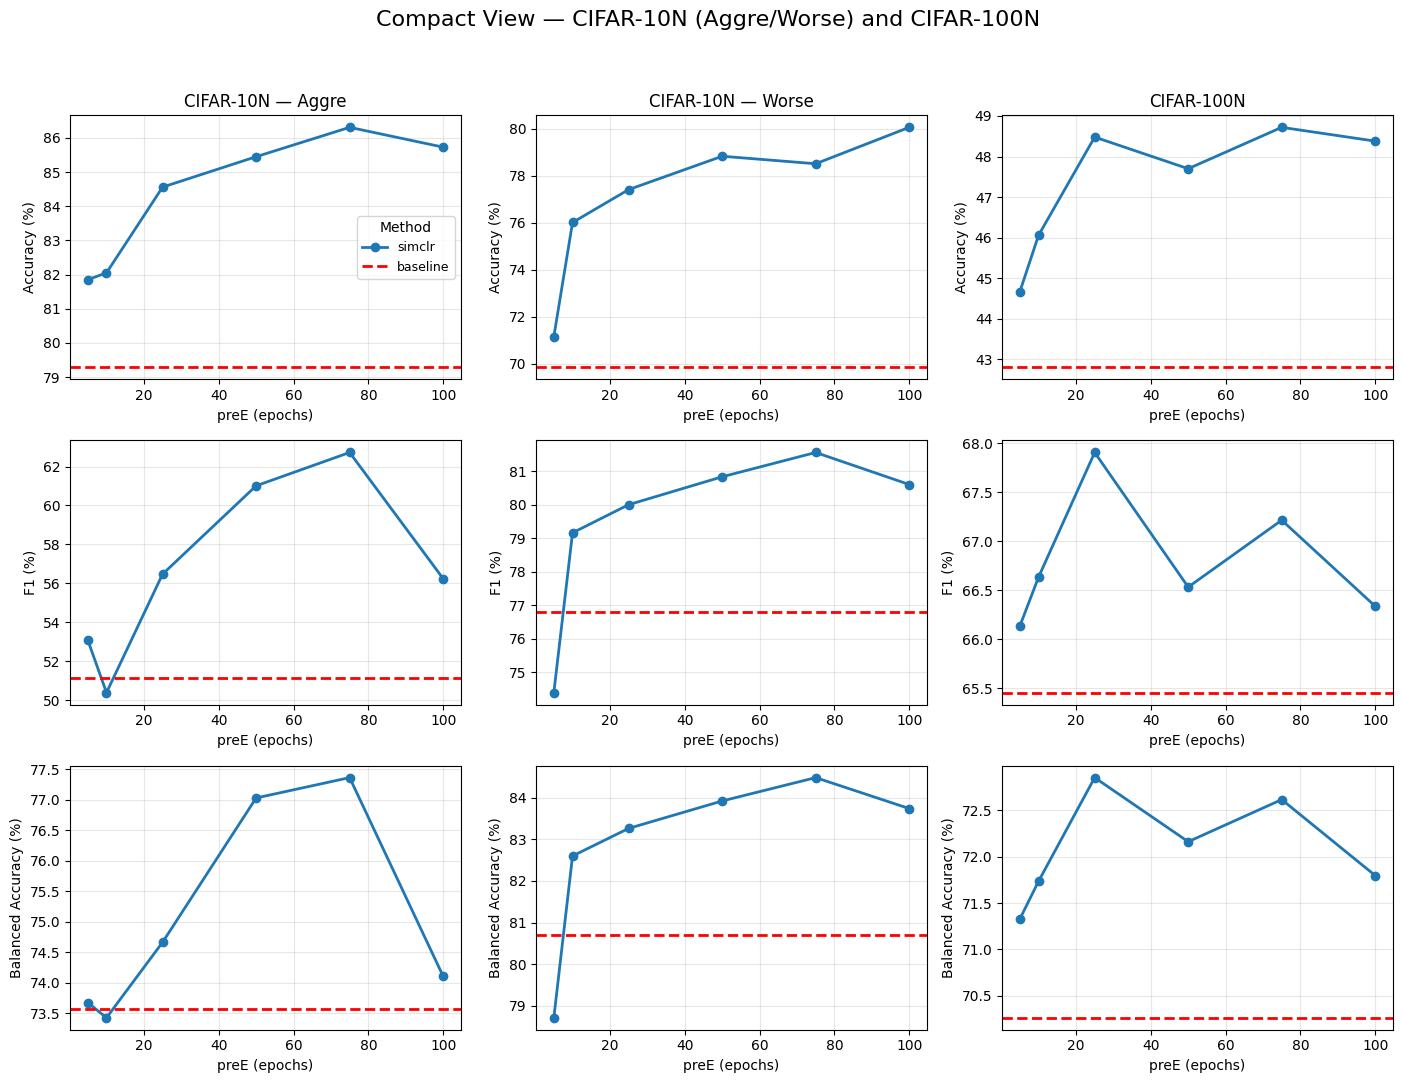

Saved summaries to: results_cifar-n/compact_summaries

=== best_per_method ===
| dataset    | variant   | ssl      |   acc |   acc_preE |    f1 |   f1_preE |   bal_acc |   bal_acc_preE |
|------------|-----------|----------|-------|------------|-------|-----------|-----------|----------------|
| cifar-100n | All       | baseline | 42.8  |          0 | 65.45 |         0 |     70.27 |              0 |
| cifar-100n | All       | simclr   | 48.72 |         75 | 67.91 |        25 |     72.85 |             25 |
| cifar-10n  | Aggre     | baseline | 79.28 |          0 | 51.13 |         0 |     73.57 |              0 |
| cifar-10n  | Aggre     | simclr   | 86.31 |         75 | 62.72 |        75 |     77.36 |             75 |
| cifar-10n  | Worse     | baseline | 69.84 |          0 | 76.81 |         0 |     80.7  |              0 |
| cifar-10n  | Worse     | simclr   | 80.06 |        100 | 81.56 |        75 |     84.49 |             75 |

=== pivot ===
| dataset    | variant   | ssl      |   pr

In [37]:
# =========================
# Compact 3x3 grid + tables
# =========================

def _compact_panel(ax, df_slice, metric_col, ylabel):
    """Draw one panel: metric vs preE for methods (baseline = dashed red)."""
    if df_slice.empty or df_slice[metric_col].isna().all():
        ax.set_axis_off()
        return

    methods = [m for m in sorted(df_slice["ssl"].unique()) if m.lower() != "baseline"]
    for method in methods:
        gm = df_slice[df_slice["ssl"]==method].sort_values("pt_epochs")
        if gm.empty or gm[metric_col].isna().all():
            continue
        ax.plot(gm["pt_epochs"], gm[metric_col], marker="o", linewidth=2, label=method)

    # baseline as dashed red horizontal line
    _add_baseline_hline(ax, df_slice, metric_col, label="baseline")

    ax.set_xlabel("preE (epochs)")
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.3)
    # keep legend only in top row to save space; caller can manage

def _canonical_slices(df):
    """
    Return list of (title, dataframe) slices in canonical order:
    [CIFAR-10N Aggre, CIFAR-10N Worse, CIFAR-100N]
    """
    slices = []
    # CIFAR-10N Aggre
    s1 = df[(df["dataset"]=="cifar-10n") & (df["variant"].str.lower()=="aggre")]
    if not s1.empty:
        slices.append(("CIFAR-10N — Aggre", s1))
    else:
        slices.append(("CIFAR-10N — Aggre", pd.DataFrame()))

    # CIFAR-10N Worse
    s2 = df[(df["dataset"]=="cifar-10n") & (df["variant"].str.lower()=="worse")]
    if not s2.empty:
        slices.append(("CIFAR-10N — Worse", s2))
    else:
        slices.append(("CIFAR-10N — Worse", pd.DataFrame()))

    # CIFAR-100N (no sub-variants)
    s3 = df[df["dataset"]=="cifar-100n"].copy()
    if not s3.empty:
        s3["variant"] = "All"
    slices.append(("CIFAR-100N", s3))
    return slices

def _make_summary_tables(df):
    """
    Build compact summary tables:
      1) mean over seeds (already) and then best per (dataset, variant, ssl) by metric
      2) a pivot table for quick scanning across preE
    Returns dict of DataFrames.
    """
    out = {}

    # Best per (dataset, variant, ssl) for each metric
    best_rows = []
    for (ds, var, ssl), g in df.groupby(["dataset","variant","ssl"]):
        # ignore baseline's preE dimension for "best" (it's 0)
        row = {"dataset": ds, "variant": var, "ssl": ssl}
        for m in ["acc","f1","bal_acc"]:
            if m in g and g[m].notna().any():
                idx = g[m].idxmax()
                row[m] = g.loc[idx, m]
                row[m+"_preE"] = int(g.loc[idx, "pt_epochs"])
        best_rows.append(row)
    out["best_per_method"] = pd.DataFrame(best_rows).sort_values(["dataset","variant","ssl"])

    # Pivot table: rows=(dataset, variant, ssl, preE), cols=metric
    pivot = df.sort_values(["dataset","variant","ssl","pt_epochs"])[
        ["dataset","variant","ssl","pt_epochs","acc","f1","bal_acc","n_seeds"]
    ].rename(columns={"pt_epochs":"preE"})
    out["pivot"] = pivot
    
    for k in out:
        out[k] = out[k].round(2)
    return out

def plot_compact_grid(base_dir: Path, save_summary: bool=False, summary_dir: Path=None):
    """
    3x3 grid (Acc/F1/BalAcc × Aggre/Worse/100N) + summary tables.
    """
    df = scan_results(base_dir)
    if df.empty:
        print(f"No data under {base_dir}")
        return df, {}

    slices = _canonical_slices(df)

    # --- Figure layout: 3 rows (metrics) x 3 cols (slices)
    fig, axes = plt.subplots(3, 3, figsize=(14, 11))
    fig.suptitle("Compact View — CIFAR-10N (Aggre/Worse) and CIFAR-100N", fontsize=16)

    metric_specs = [
        ("acc", "Accuracy (%)"),
        ("f1",  "F1 (%)" if (df["f1"].max(skipna=True) or 0) > 1.5 else "F1"),
        ("bal_acc", "Balanced Accuracy (%)" if (df["bal_acc"].max(skipna=True) or 0) > 1.5 else "Balanced Accuracy")
    ]

    # draw
    for col, (title, df_slice) in enumerate(slices):
        for row, (metric, ylabel) in enumerate(metric_specs):
            ax = axes[row, col]
            _compact_panel(ax, df_slice, metric, ylabel)
            if row == 0:
                ax.set_title(title, fontsize=12)
            # legends only on top-left panel for compactness
            if row == 0 and col == 0:
                handles, labels = ax.get_legend_handles_labels()
                if handles:
                    ax.legend(title="Method", fontsize=9)
            else:
                ax.legend().set_visible(False)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # --- Summary tables
    tables = _make_summary_tables(df)
    
    # Optionally save
    if save_summary:
        out_dir = summary_dir if summary_dir is not None else (base_dir / "compact_summaries")
        out_dir.mkdir(parents=True, exist_ok=True)
        for name, tdf in tables.items():
            tdf.to_csv(out_dir / f"{name}.csv", index=False)
        print(f"Saved summaries to: {out_dir}")

    from tabulate import tabulate
    # --- Pretty print tables with tabulate
    for name, tdf in tables.items():
        print(f"\n=== {name} ===")
        print(tabulate(tdf.head(15), headers='keys', tablefmt='github', showindex=False))
        if len(tdf) > 15:
            print(f"... ({len(tdf)} rows total)")



    # --- Compact 3-row summary: (dataset slice) × [Acc/F1/BA × (baseline, simclr)]
    best = tables["best_per_method"].copy()
    
    # Build a slice label that matches your request
    best["slice"] = np.where(
        best["dataset"].str.lower().eq("cifar-100n"),
        "cifar-100n",
        best["dataset"] + "-" + best["variant"]
    )
    
    # Keep only the three slices and the two methods we care about
    wanted_slices = ["cifar-10n-Aggre", "cifar-10n-Worse", "cifar-100n"]
    best = best[
        best["slice"].isin(wanted_slices) &
        best["ssl"].str.lower().isin(["baseline","simclr"])
    ]
    
    # Pick metrics and round
    small = best[["slice","ssl","acc","f1","bal_acc"]].round(2)
    
    # Pivot so columns are metric × method
    wide = small.pivot(index="slice", columns="ssl", values=["acc","f1","bal_acc"])
    
    # Order rows and columns, and give friendly column names
    row_order = ["cifar-10n-Aggre", "cifar-10n-Worse", "cifar-100n"]
    wide = wide.reindex(row_order)
    
    # Flatten MultiIndex columns
    wide.columns = [
        ("Acc_" if a=="acc" else "F1_" if a=="f1" else "BA_") + b
        for a, b in wide.columns
    ]
    
    # Column order: baseline first, then simclr
    col_order = ["Acc_baseline","Acc_simclr","F1_baseline","F1_simclr","BA_baseline","BA_simclr"]
    wide = wide.reindex(columns=col_order)
    
    # Final tidy table
    compact_table = wide.reset_index().rename(columns={"slice":"dataset"}).fillna("—")
    
    # Pretty-print with tabulate
    print("\n=== compact_summary (best per dataset × method) ===")
    print(tabulate(compact_table, headers="keys", tablefmt="github", showindex=False))
    
    


    
        
    return df, tables

# =========================
# Example call
# =========================
BASE_DIR = Path("results_cifar-n")
df_all, summary = plot_compact_grid(BASE_DIR, save_summary=True)
